# Copyright Netherlands eScience Center <br>
** Function     : Energy budget - AMET (ERAI, MERRA2, JRA55) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.18 ** <br>
** Last Update  : 2018.10.10 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. The full energy budget of the Arctic is inspected here to account for the flow of energy and the residuals.<br>
The sea ice volume comes from a independent dataset - PIOMASS (from 1979-2017, unit 10^3 km3). <br>
Return Values : jpeg <br>
Caveat!         : The AMET is computed as the residual of net flux at TOA and surface. <br>
For all the flux generated by ECMWF model, **downward is positive** (regardless of the standard name). So it is with **ERA-Interim** <br>
While for the flux in **MERRA2**, the **positive sign** for each variable varies:<br>
* Net shortwave radiation at surface - downward <br>
* Net shortwave radiation at TOA - downward <br>
* Net longwave radiation at surface - downward <br>
* Upwelling longwave radiation at TOA - upward <br>
* Total latent energy flux - upward <br>
* Sensible heat flux - upward <br>

While for the flux in **JRA55**, the **positive sign** for each variable varies:<br>
* Latent heat flux - upward <br>
* Sensible heat flux - upward <br>
* Downward solar radiation flux at TOA - downward <br>
* Downward solar radiation flux at surface - downward <br>
* Downward longwave radiation flux at surface - downward <br>
* Upward solar radiation flux at TOA - upward <br>
* Upward solar radiation flux at surface - upward <br>
* Upward longwave radiation flux at TOA - upward <br>
* Upward longwave radiation flux at surface - upward <br>

Here we use the net radiation flux of JRA55 after post-processing, as follows: <br>
* Net radiation at TOA - downward <br>
* Net radiation at surface - downward <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from scipy import stats
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
# index of latitude for insteret
# 60N (after cut)

lat_ERAI_60_SH = 57
#lat_MERRA2_60_SH = 80
lat_JRA55_60_SH = 267

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ERAI_AMET = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
    datapath_MERRA2_AMET = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_AMET = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
    datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'    
    datapath_PIOMAS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/budget/SH'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI_AMET,
                                             'era_model_subdaily_1979_2017_amet_SH.nc'))
    dataset_MERRA2_AMET = Dataset(os.path.join(datapath_MERRA2_AMET,
                                               'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc'))
    dataset_JRA55_AMET = Dataset(os.path.join(datapath_JRA55_AMET,
                                              'jra_model_subdaily_1979_2016_amet_SH.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath,
                                             'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    dataset_MERRA2_fields_flux = Dataset(os.path.join(datapath_MERRA2_fields,
                                                      'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
    dataset_JRA55_fields_flux = Dataset(os.path.join(datapath_JRA55_fields,
                                                     'surface_JRA55_monthly_model_regress_SFlux_Rad_1979_2013.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_int_ERAI = dataset_ERAI_AMET.variables['E_int'][:,:,156:]/1000 # from Tera Watt to Peta Watt
    AMET_int_MERRA2 = dataset_MERRA2_AMET.variables['E'][:]/1000
    AMET_int_JRA55 = dataset_JRA55_AMET.variables['E_int'][:,:,195:]/1000
    # 3D fields [year, month, lat]
    OHC_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_int'][21:,:,180:]/1000 # from Tera Joule to Peta Joule 
    OHC_atl_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_int'][21:,:,180:]/1000 # start from 1979
    # 3D fields [year, month, lat]
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:]
    SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:,:,180:]/1000
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:,:,180:]/1000
    #SIC_ERAI[SIC_ERAI_mask==True] = 0
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:]    # from 1979 to 2017
    year_ERAI = dataset_ERAI_AMET.variables['year']            # from 1979 to 2017
    year_MERRA2 = dataset_MERRA2_AMET.variables['year']    # from 1980 to 2016
    year_JRA55 = dataset_JRA55_AMET.variables['year']    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][156:]
    latitude_AMET_MERRA2 = dataset_MERRA2_AMET.variables['latitude'][:]
    latitude_AMET_JRA55 = dataset_JRA55_AMET.variables['latitude'][195:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][:]
    longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
    latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
    longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]

*********************** extract variables *************************


In [25]:
    #####################################################################################
    print ('*********************** post-process 4D fields *************************')    
    # 4D fields [year, month, level, lat]
    # downward is positive for all the fluxes
    print ('*********************** post-process era fields *************************')
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:,:,:94,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:,:,:94,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:,:,:94,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:,:,:94,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:,:,:94,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:,:,:94,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI[:] + rad_long_surf_ERAI[:] +\
                         SFlux_sensible_ERAI[:] + SFlux_latent_ERAI[:]
    net_flux_toa_ERAI = rad_short_toa_ERAI[:] + rad_long_toa_ERAI[:]    
    # save memory
    del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
    del SFlux_sensible_ERAI, SFlux_latent_ERAI    
    print ('*********************** post-process merra fields *************************')
    rad_short_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['SWTNT'][:-1,:,220:,:]
    rad_long_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['LWTUP'][:-1,:,220:,:]
    rad_short_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['SWGNT'][:-1,:,220:,:]
    rad_long_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['LWGNT'][:-1,:,220:,:]
    SFlux_sensible_MERRA2 = dataset_MERRA2_fields_flux.variables['HFLUX'][:-1,:,220:,:]
    SFlux_latent_MERRA2 = dataset_MERRA2_fields_flux.variables['EFLUX'][:-1,:,220:,:]
    # calculate total net energy flux at TOA/surface
    # merra - watch out! the sign
    net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:] + rad_long_surf_MERRA2[:] -\
                           SFlux_sensible_MERRA2[:] - SFlux_latent_MERRA2[:]
    net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:] - rad_long_toa_MERRA2[:]
    del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
    del SFlux_sensible_MERRA2, SFlux_latent_MERRA2
    print ('*********************** post-process jra fields *************************')
    rad_net_toa_JRA55 = dataset_JRA55_fields_flux.variables['nRadT'][:,:,:125,:]
    rad_net_surf_JRA55 = dataset_JRA55_fields_flux.variables['nRadS'][:,:,:125,:]
    SFlux_sensible_JRA55 = dataset_JRA55_fields_flux.variables['SFlux'][:,:,:125,:]
    SFlux_latent_JRA55 = dataset_JRA55_fields_flux.variables['LFlux'][:,:,:125,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_JRA55 = rad_net_surf_JRA55[:] + SFlux_sensible_JRA55[:] +\
                          SFlux_latent_JRA55[:]
    net_flux_toa_JRA55 = rad_net_toa_JRA55[:]
    del rad_net_surf_JRA55, SFlux_sensible_JRA55, SFlux_latent_JRA55
    print ('*********************** convert W/m2 to  *************************')
    # area weighted surface flux
    # era
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float)
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    # merra
    net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float)
    net_flux_toa_MERRA2_area = np.zeros(net_flux_toa_MERRA2.shape, dtype=float)
    # jra
    net_flux_surf_JRA55_area = np.zeros(net_flux_surf_JRA55.shape, dtype=float)
    net_flux_toa_JRA55_area = np.zeros(net_flux_toa_JRA55.shape, dtype=float) 
    #size of the grid box
    # era
    dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI[:94] /
                                            360) / len(longitude_fields_ERAI) 
    dy_ERAI = np.pi * constant['R'] / len(latitude_fields_ERAI)
    # merra
    dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_MERRA2[220:] /
                                            360) / len(longitude_fields_MERRA2) 
    dy_MERRA2 = np.pi * constant['R'] / len(latitude_fields_MERRA2)
    # jra
    dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_JRA55[:125] /
                                            360) / len(longitude_fields_JRA55) 
    dy_JRA55 = np.pi * constant['R'] / len(latitude_fields_JRA55)   
    # era
    for i in np.arange(len(latitude_fields_ERAI[:94])):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                           dy_ERAI / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                          dy_ERAI / 1E+12
    # merra
    for i in np.arange(len(latitude_fields_MERRA2[220:])):
        # change the unit to terawatt
        net_flux_surf_MERRA2_area[:,:,i,:] = net_flux_surf_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                           dy_MERRA2 / 1E+12
        net_flux_toa_MERRA2_area[:,:,i,:] = net_flux_toa_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                          dy_MERRA2 / 1E+12
    # jra
    for i in np.arange(len(latitude_fields_JRA55[:125])):
        # change the unit to terawatt
        net_flux_surf_JRA55_area[:,:,i,:] = net_flux_surf_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                           dy_JRA55 / 1E+12
        net_flux_toa_JRA55_area[:,:,i,:] = net_flux_toa_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                          dy_JRA55 / 1E+12

*********************** post-process 4D fields *************************
*********************** post-process era fields *************************
*********************** post-process merra fields *************************
*********************** post-process jra fields *************************
*********************** convert W/m2 to  *************************


In [24]:
    # get sea ice volume from PIOMASS - 10^3 km3
    ice_volume = np.loadtxt(os.path.join(datapath_PIOMAS,'PIOMAS.2sst.monthly.Current.v2.1.txt'), # 1979-2017
                            unpack=False)
    # drop the first column
    ice_volume = ice_volume[:,1:]
    y, x = ice_volume.shape
    # convert to series
    ice_volume_series = ice_volume.reshape(y*x)

In [39]:
    # check the latitude
    #print (ice_volume_series)
    print (latitude_OMET_ORAS4[53:55])
    print (latitude_AMET_ERAI[57])
    print (latitude_fields_ERAI[40])
    print (latitude_AMET_MERRA2[80])
    print (latitude_fields_MERRA2[220:])
    print (latitude_AMET_JRA55[71])
    #print (latitude_fields_JRA55[:125])

[60.018433 60.629475]
59.999813
60.0
60.0
[20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5
 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5
 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5
 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5
 48.  48.5 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5
 55.  55.5 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5
 62.  62.5 63.  63.5 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5
 69.  69.5 70.  70.5 71.  71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5
 76.  76.5 77.  77.5 78.  78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5
 83.  83.5 84.  84.5 85.  85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5
 90. ]
59.81267


In [27]:
    # calculate the tendency of OHC
    # apply the central scheme
    OHC_int_ORAS4_series = OHC_int_ORAS4.reshape(len(year_ORAS4)*12,
                                                 len(latitude_OMET_ORAS4))
    OHC_tend_int_ORAS4 = np.zeros(OHC_int_ORAS4_series.shape,dtype=float)
    for i in np.arange(len(year_ORAS4)*12-2):
        # skip the first and the last value
        OHC_tend_int_ORAS4[i+1,:] = ((OHC_int_ORAS4_series[i+2,:]
                                     - OHC_int_ORAS4_series[i,:]) / (2 * 30 * 24 *3600))
    # take the integral of radiation at TOA
    # era
    net_flux_toa_int_ERAI_area = np.sum(net_flux_toa_ERAI_area,3) / 1000 # from tera watt to peta watt
    net_flux_toa_int_ERAI_area_series = net_flux_toa_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                           len(latitude_fields_ERAI[:94]))
    net_flux_surf_int_ERAI_area = np.sum(net_flux_surf_ERAI_area,3) / 1000
    net_flux_surf_int_ERAI_area_series = net_flux_surf_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                             len(latitude_fields_ERAI[:94]))    
    # merra
    net_flux_toa_int_MERRA2_area = np.sum(net_flux_toa_MERRA2_area,3) / 1000 # from tera watt to peta watt
    net_flux_toa_int_MERRA2_area_series = net_flux_toa_int_MERRA2_area.reshape(len(year_MERRA2)*12,
                                                                               len(latitude_fields_MERRA2[220:]))
    net_flux_surf_int_MERRA2_area = np.sum(net_flux_surf_MERRA2_area,3) / 1000
    net_flux_surf_int_MERRA2_area_series = net_flux_surf_int_MERRA2_area.reshape(len(year_MERRA2)*12,
                                                                                 len(latitude_fields_MERRA2[220:]))     
    # jra
    net_flux_toa_int_JRA55_area = np.sum(net_flux_toa_JRA55_area,3) / 1000 # from tera watt to peta watt
    net_flux_toa_int_JRA55_area_series = net_flux_toa_int_JRA55_area.reshape(len(year_JRA55[:-3])*12,
                                                                             len(latitude_fields_JRA55[:125]))
    net_flux_surf_int_JRA55_area = np.sum(net_flux_surf_JRA55_area,3) / 1000
    net_flux_surf_int_JRA55_area_series = net_flux_surf_int_JRA55_area.reshape(len(year_JRA55[:-3])*12,
                                                                               len(latitude_fields_JRA55[:125]))     
        
    # take the time series of MET
    AMET_int_ERAI_series = AMET_int_ERAI.reshape(len(year_ERAI)*12,
                                                 len(latitude_AMET_ERAI))
    AMET_int_MERRA2_series = AMET_int_MERRA2.reshape(len(year_MERRA2)*12,
                                                     len(latitude_AMET_MERRA2))
    AMET_int_JRA55_series = AMET_int_JRA55.reshape(len(year_JRA55)*12,
                                                   len(latitude_AMET_JRA55))
    OMET_int_ORAS4_series = OMET_int_ORAS4.reshape(len(year_ORAS4)*12,
                                                  len(latitude_OMET_ORAS4))
    # calculate the tendency of sea ice
    print ('We use the volume of sea ice to calculate the heat loss.')
    ice_tend_PIOMAS = np.zeros(ice_volume_series.shape,dtype=float)
    for i in np.arange(len(ice_tend_PIOMAS)-2):
        # skip the first and the last value
        ice_tend_PIOMAS[i+1] = ((ice_volume_series[i+2] - ice_volume_series[i])\
                                * 1000 * 1000**3 / (2 * 30 * 24 *3600))
    Heat_ice_tend_PIOMAS = ice_tend_PIOMAS  *\
                           constant['rho_ice'] * 1000 * constant['HoF'] * 1000 / 1E+15 # PW

We use the volume of sea ice to calculate the heat loss.


In [ ]:
    print (Heat_ice_tend_PIOMAS)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET div & OMET 60N - 90N  ======================


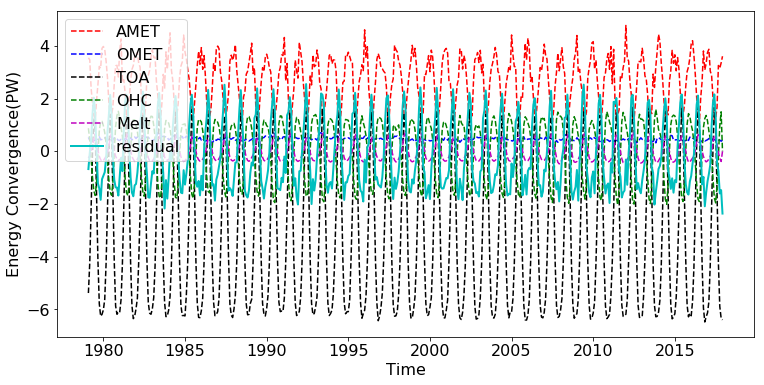

mean of residual
-0.1356930088153378
mean of AMET
3.988577669131424
mean of OMET
0.47197558384635974
mean of Rtoa
-3.3113231663930054
mean of OHC
-0.018625720621293
mean of SIC
0.004526970037935869


In [31]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET div & OMET 60N - 90N  ======================')
    residual_overall = AMET_int_ERAI_series[1:,57] + OMET_int_ORAS4_series[1:,53] +\
                       np.sum(net_flux_toa_int_ERAI_area_series[1:,:41],1) -\
                       np.sum(OHC_tend_int_ORAS4[1:,53:],1) -\
                       Heat_ice_tend_PIOMAS[1:]
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2017
    
    fig1 = plt.figure()
    fig1.set_size_inches(12.5, 6)
    plt.plot(index[1:], AMET_int_ERAI_series[1:,57],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:], OMET_int_ORAS4_series[1:,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:], np.sum(net_flux_toa_int_ERAI_area_series[1:,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:], np.sum(-OHC_tend_int_ORAS4[1:,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:], -Heat_ice_tend_PIOMAS[1:],
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:], residual_overall,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'energy_budget_overall_erai_oras.png'),dpi=300)
    plt.close(fig1)
    # statistics
    print('mean of residual')
    print(np.mean(residual_overall))
    print('mean of AMET')
    print(np.mean(AMET_int_ERAI_series[1:,40]))
    print('mean of OMET')
    print(np.mean(OMET_int_ORAS4_series[1:,53]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_ERAI_area_series[1:,:41],1)))
    print('mean of OHC')
    print(np.mean(np.sum(-OHC_tend_int_ORAS4[1:,53:],1)))
    print('mean of SIC')
    print(np.mean(-Heat_ice_tend_PIOMAS[1:]))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ERAI  !@#$%^&***********
===================  AMET div TOA SFlux 60N - 90N  ===================


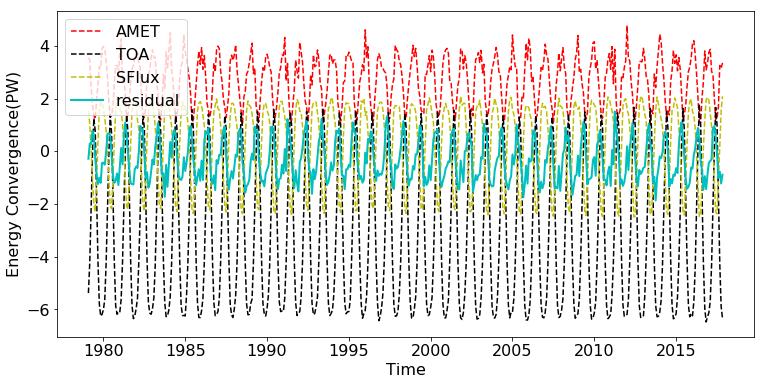

mean of residual
-0.338293867662361
mean of AMET
2.7158391731491416
mean of Rtoa
-3.3047039503402895
mean of SFlux
0.25057097424970975


In [33]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ERAI  !@#$%^&***********')
    print ('===================  AMET div TOA SFlux 60N - 90N  ===================')
    residual_atmos = AMET_int_ERAI_series[1:-1,57] +\
                     np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) -\
                     np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2016
    
    fig2 = plt.figure()
    fig2.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], AMET_int_ERAI_series[1:-1,57],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-net_flux_surf_int_ERAI_area_series[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], residual_atmos,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig2.savefig(os.path.join(output_path,'energy_budget_atmosphere_erai.png'),dpi=300)
    plt.close(fig2)
    # statistics
    print('mean of residual')
    print(np.mean(residual_atmos))
    print('mean of AMET')
    print(np.mean(AMET_int_ERAI_series[1:-1,57]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1)))    
    print('mean of SFlux')
    print(np.mean(np.sum(-net_flux_surf_int_ERAI_area_series[1:-1,:41],1)))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of MERRA2  !@#$%^&***********
===================  AMET div TOA SFlux 60N - 90N  ===================


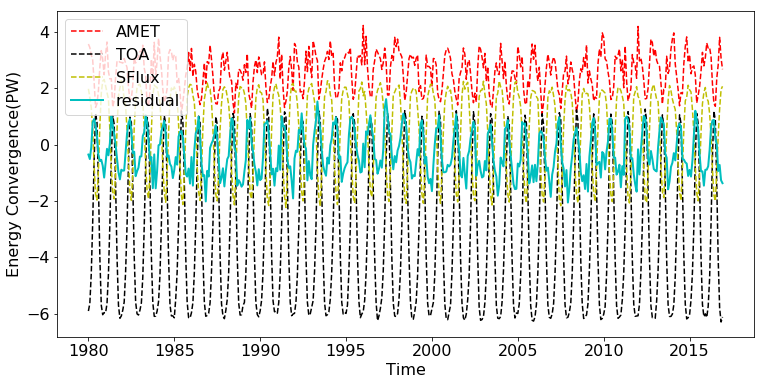

mean of residual
-0.29826078280885365
mean of AMET
2.5806875596456087
mean of Rtoa
-3.408077116027356
mean of SFlux
0.5291287735728931


In [37]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of MERRA2  !@#$%^&***********')
    print ('===================  AMET div TOA SFlux 60N - 90N  ===================')
    residual_atmos = AMET_int_MERRA2_series[:,80] +\
                     np.sum(net_flux_toa_int_MERRA2_area_series[:,300:],1) -\
                     np.sum(net_flux_surf_int_MERRA2_area_series[:,300:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig21 = plt.figure()
    fig21.set_size_inches(12.5, 6)
    plt.plot(index[12:], AMET_int_MERRA2_series[:,80],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[12:], np.sum(net_flux_toa_int_MERRA2_area_series[:,300:],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[12:], np.sum(-net_flux_surf_int_MERRA2_area_series[:,300:],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[12:], residual_atmos,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig21.savefig(os.path.join(output_path,'energy_budget_atmosphere_merra.png'),dpi=300)
    plt.close(fig21)
    # statistics
    print('mean of residual')
    print(np.mean(residual_atmos))
    print('mean of AMET')
    print(np.mean(AMET_int_MERRA2_series[:,80]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_MERRA2_area_series[:,300:],1)))    
    print('mean of SFlux')
    print(np.mean(np.sum(-net_flux_surf_int_MERRA2_area_series[:,300:],1)))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of JRA55  !@#$%^&***********
===================  AMET div TOA SFlux 60N - 90N  ===================


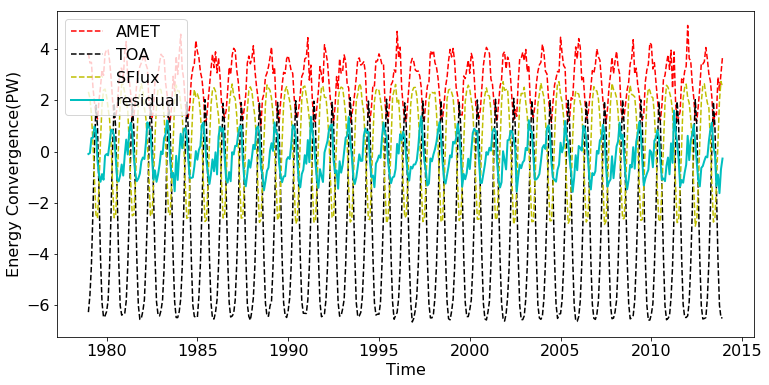

mean of residual
-0.1717837541130874
mean of AMET
3.7741450557002314
mean of Rtoa
-3.342218652338542
mean of SFlux
0.4455160437050202


In [40]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of JRA55  !@#$%^&***********')
    print ('===================  AMET div TOA SFlux 60N - 90N  ===================')
    residual_atmos = AMET_int_JRA55_series[:-36,71] +\
                     np.sum(net_flux_toa_int_JRA55_area_series[:,:54],1) -\
                     np.sum(net_flux_surf_int_JRA55_area_series[:,:54],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig22 = plt.figure()
    fig22.set_size_inches(12.5, 6)
    plt.plot(index[:-36], AMET_int_JRA55_series[:-36,71],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[:-36], np.sum(net_flux_toa_int_JRA55_area_series[:,:54],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[:-36], np.sum(-net_flux_surf_int_JRA55_area_series[:,:54],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[:-36], residual_atmos,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig22.savefig(os.path.join(output_path,'energy_budget_atmosphere_jra.png'),dpi=300)
    plt.close(fig22)
    # statistics
    print('mean of residual')
    print(np.mean(residual_atmos))
    print('mean of AMET')
    print(np.mean(AMET_int_JRA55_series[:-24,53]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_JRA55_area_series[:,:54],1)))    
    print('mean of SFlux')
    print(np.mean(np.sum(-net_flux_surf_int_JRA55_area_series[:,:54],1)))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4!  @#$%^&***********
======================  OMET OHC SFlux 60N - 90N ========================


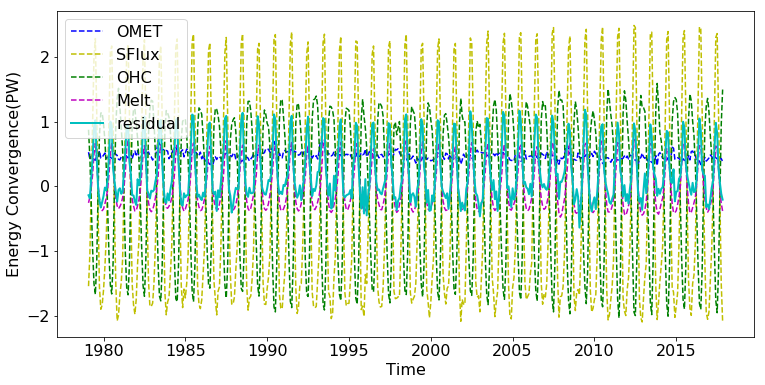

mean of residual
0.20283886219413788


In [49]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4!  @#$%^&***********')
    print ('======================  OMET OHC SFlux 60N - 90N ========================')
    residual_ocean = OMET_int_ORAS4_series[1:-1,53] +\
                     np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1) -\
                     np.sum(OHC_tend_int_ORAS4[1:-1,53:],1)
                     #np.sum(Heat_SIC_tend_int_ERAI_area[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2016
    fig3 = plt.figure()
    fig3.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], OMET_int_ORAS4_series[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_ORAS4[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],-Heat_ice_tend_PIOMAS[1:-1],
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_ocean,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig3.savefig(os.path.join(output_path,'energy_budget_ocean.png'),dpi=300)
    plt.close(fig3)
    # statistics
    print('mean of residual')
    print(np.mean(residual_ocean))

In [42]:
    print ('*******************           postprocess           ******************')
    print ('===================  AMET & OMET anomalies 60N-90N  ==================')
    # take anomalies
    print ('===================  ERAI  ==================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_int_ERAI_series)
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_Rtoa_ERAI = meta.statistics.operator(net_flux_toa_int_ERAI_area_series)
    stat_Rtoa_ERAI.anomaly(Dim_month=False)
    stat_SFlux_ERAI = meta.statistics.operator(net_flux_surf_int_ERAI_area_series)
    stat_SFlux_ERAI.anomaly(Dim_month=False)
    print ('===================  MERRA2  ==================')
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_int_MERRA2_series)
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_Rtoa_MERRA2 = meta.statistics.operator(net_flux_toa_int_MERRA2_area_series)
    stat_Rtoa_MERRA2.anomaly(Dim_month=False)
    stat_SFlux_MERRA2 = meta.statistics.operator(net_flux_surf_int_MERRA2_area_series)
    stat_SFlux_MERRA2.anomaly(Dim_month=False) 
    print ('===================  JRA55  ==================')
    stat_AMET_JRA55 = meta.statistics.operator(AMET_int_JRA55_series)
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_Rtoa_JRA55 = meta.statistics.operator(net_flux_toa_int_JRA55_area_series)
    stat_Rtoa_JRA55.anomaly(Dim_month=False)
    stat_SFlux_JRA55 = meta.statistics.operator(net_flux_surf_int_JRA55_area_series)
    stat_SFlux_JRA55.anomaly(Dim_month=False)     
    print ('===================  ORAS4  ==================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_int_ORAS4_series)
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_int_ORAS4_series)
    stat_OHC_ORAS4.anomaly(Dim_month=False)
    print ('===================  PIOMAS  ==================')
    stat_SIC_PIOMAS = meta.statistics.operator(ice_volume_series)
    stat_SIC_PIOMAS.anomaly(Dim_month=False)
    # calculate the tendency of OHC anomalies
    OHC_tend_int_anomaly = np.zeros(stat_OHC_ORAS4._anomaly.shape,dtype=float)
    for i in np.arange(len(year_ORAS4)*12-2):
        # skip the first and the last value
        OHC_tend_int_anomaly[i+1,:] = ((stat_OHC_ORAS4._anomaly[i+2,:]
                                     - stat_OHC_ORAS4._anomaly[i,:]) / (2 * 30 * 24 *3600))
    # calculate the tendency of ice heat absorbsion anomalies
    ice_tend_PIOMAS_anomaly = np.zeros(ice_volume_series.shape,dtype=float)
    for i in np.arange(len(ice_tend_PIOMAS)-2):
        ice_tend_PIOMAS_anomaly[i+1] = ((stat_SIC_PIOMAS._anomaly[i+2] - 
                                         stat_SIC_PIOMAS._anomaly[i])\
                                        * 1000 * 1000**3 / (2 * 30 * 24 *3600))
    Heat_ice_tend_PIOMAS_anomaly = ice_tend_PIOMAS_anomaly * constant['rho_ice']\
                                   * 1000 * constant['HoF'] * 1000 / 1E+15 # PW    

*******************           postprocess           ******************
===================  AMET & OMET anomalies 60N-90N  ==================
===================  ERAI  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
===================  MERRA2  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
===================  JRA55  ====

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET & OMET anomalies 60N-90N  ==================


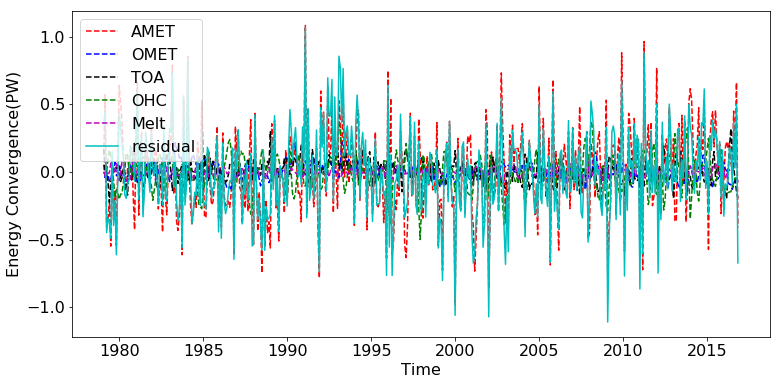

Correlation AMET-Residual
0.8958896614374324
Correlation Rtoa-Residual
0.0664525164960487
Correlation OHC-Residual
0.16869478489038361


In [13]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET & OMET anomalies 60N-90N  ==================')
    residual_overall_anomaly = stat_AMET_ERAI._anomaly[1:,40] + stat_OMET_ORAS4._anomaly[1:,53] +\
                               np.sum(stat_Rtoa_ERAI._anomaly[1:,:41],1) -\
                               np.sum(OHC_tend_int_anomaly[1:,53:],1) -\
                               Heat_ice_tend_PIOMAS_anomaly[1:-12]
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig4 = plt.figure()
    fig4.set_size_inches(12.5, 6)
    plt.plot(index[1:], stat_AMET_ERAI._anomaly[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:], residual_overall_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig4.savefig(os.path.join(output_path,'energy_budget_overall_anomaly_erai_oras.png'),dpi=300)
    plt.close(fig4)
    # statistics
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                               stat_AMET_ERAI._anomaly[1:,40])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation OHC-Residual')
    _, _, Corr_OHC_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                                np.sum(-OHC_tend_int_anomaly[1:,53:],1))
    print (Corr_OHC_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  AMET TOA SFlux anomalies 60N - 90N ========================


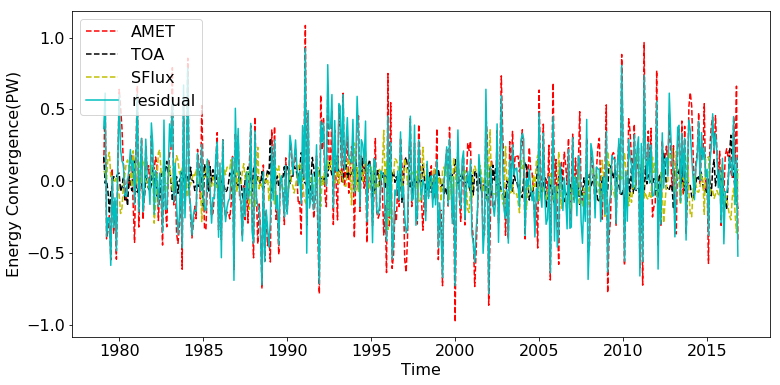

mean of residual
-2.85859156521165e-05
Correlation AMET-Residual
0.8990307841203034
Correlation Rtoa-Residual
0.08476455094144089
Correlation SFlux-Residual
-0.018992910512876552


In [7]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ERAI  !@#$%^&***********')
    print ('======================  AMET TOA SFlux anomalies 60N - 90N ========================')
    residual_atmos_anomaly = stat_AMET_ERAI._anomaly[1:-1,40] +\
                             np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1) -\
                             np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig5 = plt.figure()
    fig5.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_AMET_ERAI._anomaly[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-stat_SFlux_ERAI._anomaly[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], residual_atmos_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig5.savefig(os.path.join(output_path,'energy_budget_atmosphere_anomaly_erai.png'),dpi=300)
    plt.close(fig5)
    
    print('mean of residual')
    print(np.mean(residual_atmos_anomaly))
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                               stat_AMET_ERAI._anomaly[1:-1,40])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation SFlux-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(-stat_SFlux_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of MERRA2  !@#$%^&***********
======================  AMET TOA SFlux anomalies 60N - 90N ========================


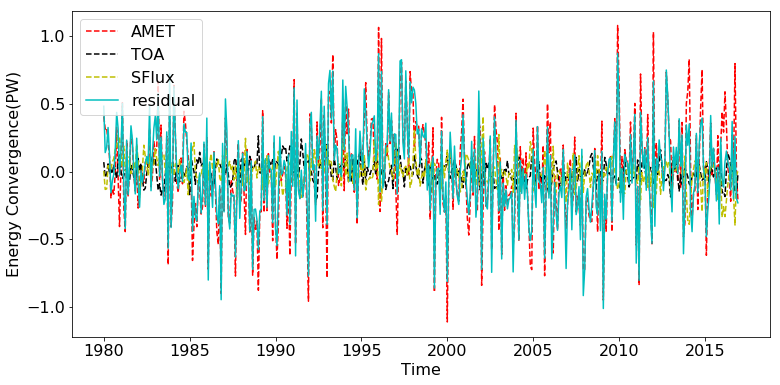

mean of residual
-1.240249144626301e-16
Correlation AMET-Residual
0.9197081829748065
Correlation Rtoa-Residual
-0.002088870466463637
Correlation SFlux-Residual
0.05151079232112343


In [43]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of MERRA2  !@#$%^&***********')
    print ('======================  AMET TOA SFlux anomalies 60N - 90N ========================')
    residual_atmos_anomaly = stat_AMET_MERRA2._anomaly[:,80] +\
                             np.sum(stat_Rtoa_MERRA2._anomaly[:,300:],1) -\
                             np.sum(stat_SFlux_MERRA2._anomaly[:,300:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig51 = plt.figure()
    fig51.set_size_inches(12.5, 6)
    plt.plot(index[12:], stat_AMET_MERRA2._anomaly[:,80],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[12:], np.sum(stat_Rtoa_MERRA2._anomaly[:,300:],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[12:], np.sum(-stat_SFlux_MERRA2._anomaly[:,300:],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[12:], residual_atmos_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig51.savefig(os.path.join(output_path,'energy_budget_atmosphere_anomaly_merra.png'),dpi=300)
    plt.close(fig51)
    
    print('mean of residual')
    print(np.mean(residual_atmos_anomaly))
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 stat_AMET_MERRA2._anomaly[:,80])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(stat_Rtoa_MERRA2._anomaly[:,300:],1))
    print (Corr_Rtoa_Res)
    print ('Correlation SFlux-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(-stat_SFlux_MERRA2._anomaly[:,300:],1))
    print (Corr_Rtoa_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of JRA55  !@#$%^&***********
======================  AMET TOA SFlux anomalies 60N - 90N ========================


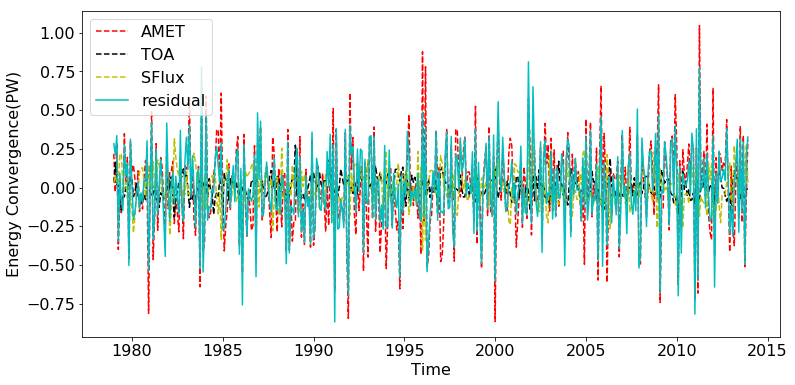

mean of residual
-0.0028960070432537443
Correlation AMET-Residual
0.8818132057358614
Correlation Rtoa-Residual
-0.0010620698918046736
Correlation SFlux-Residual
0.07224118027507323


In [45]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of JRA55  !@#$%^&***********')
    print ('======================  AMET TOA SFlux anomalies 60N - 90N ========================')
    residual_atmos_anomaly = stat_AMET_JRA55._anomaly[:-24,53] +\
                             np.sum(stat_Rtoa_JRA55._anomaly[:,:54],1) -\
                             np.sum(stat_SFlux_JRA55._anomaly[:,:54],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig52 = plt.figure()
    fig52.set_size_inches(12.5, 6)
    plt.plot(index[:-36], stat_AMET_JRA55._anomaly[:-24,53],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[:-36], np.sum(stat_Rtoa_JRA55._anomaly[:,:54],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[:-36], np.sum(-stat_SFlux_JRA55._anomaly[:,:54],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[:-36], residual_atmos_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig52.savefig(os.path.join(output_path,'energy_budget_atmosphere_anomaly_jra.png'),dpi=300)
    plt.close(fig52)
    
    print('mean of residual')
    print(np.mean(residual_atmos_anomaly))
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 stat_AMET_JRA55._anomaly[:-24,53])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(stat_Rtoa_JRA55._anomaly[:,:54],1))
    print (Corr_Rtoa_Res)
    print ('Correlation SFlux-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(-stat_SFlux_JRA55._anomaly[:,:54],1))
    print (Corr_Rtoa_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  OMET OHC SFlux anomalies 60N - 90N ========================


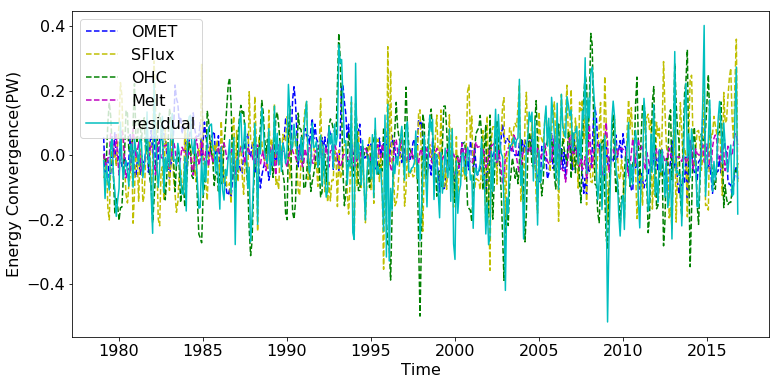

In [15]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 !@#$%^&***********')
    print ('======================  OMET OHC SFlux anomalies 60N - 90N ========================')
    residual_ocean_anomaly = stat_OMET_ORAS4._anomaly[1:-1,53] +\
                             np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1) -\
                             np.sum(OHC_tend_int_anomaly[1:-1,53:],1)
                             #np.sum(Heat_SIC_tend_int_anomaly[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    fig6 = plt.figure()
    fig6.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_ocean_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig6.savefig(os.path.join(output_path,'energy_budget_ocean_anomaly.png'),dpi=300)
    plt.close(fig3)

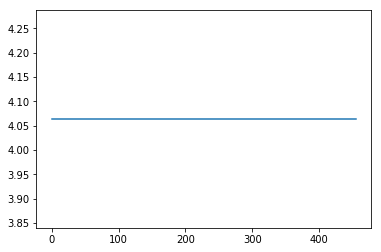

In [6]:
    # Estimation of the possible leakage of energy given by ECMWF
    # Berriford et. al. 2011. Atmospheric conservation properties in ERA-Interim.
    # Check for the residual of 8 PW and its contribution in the Arctic (60N -90N)
    residual_ECMWF_ERAI = np.ones(net_flux_toa_ERAI.shape, dtype=float)
    residual_ECMWF_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        residual_ECMWF_ERAI_area[:,:,i,:] = residual_ECMWF_ERAI[:,:,i,:] * 8 * dx[i] * dy / 1E+12
    # take the zonal integral
    residual_ECMWF_int_ERAI_area = np.sum(residual_ECMWF_ERAI_area,3)
    residual_ECMWF_int_ERAI_area_series = residual_ECMWF_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                               len(latitude_fields_ERAI))
    plt.plot(np.sum(residual_ECMWF_int_ERAI_area_series[:,:],1)/1000)

-4.305690232524865


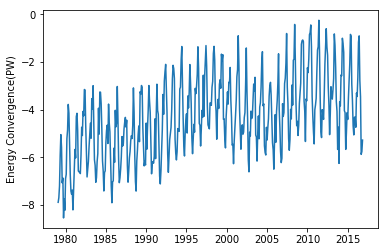

In [21]:
    # Estimation of the possible leakage of energy given by ECMWF
    # Global mean of TOA - SFlux
    residual_global_atmos = np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:],1) -\
                            np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:],1)
    plt.plot(index[1:-1], residual_global_atmos)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year)
    plt.ylabel("Energy Convergence(PW)")
    
    print (np.mean(residual_global_atmos))

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET & OMET anomalies 60N-90N lowpass 5 year  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


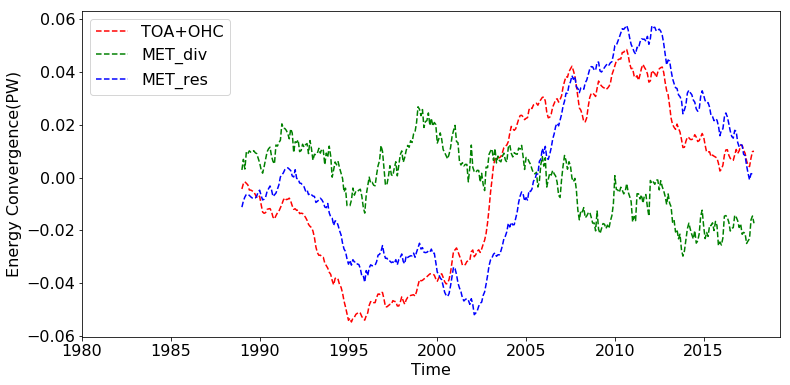

In [50]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET & OMET anomalies 60N-90N lowpass 5 year  ==================')
    AMET_residual = -(np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) - 
                      np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1))
    TOA_OHC = np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) - np.sum(OHC_tend_int_ORAS4[1:-1,53:],1)
    MET_sum_div = AMET_int_ERAI_series[1:-1,57] + OMET_int_ORAS4_series[1:-1,53]
    MET_sum_res = AMET_residual + OMET_int_ORAS4_series[1:-1,53]
    # take the running mean
    stat_TOA_OHC = meta.statistics.operator(-TOA_OHC)
    stat_TOA_OHC.anomaly(Dim_month=False)
    stat_TOA_OHC.lowpass(window=120)
    stat_MET_div = meta.statistics.operator(MET_sum_div)
    stat_MET_div.anomaly(Dim_month=False)
    stat_MET_div.lowpass(window=120)
    stat_MET_res = meta.statistics.operator(MET_sum_res)
    stat_MET_res.anomaly(Dim_month=False)
    stat_MET_res.lowpass(window=120)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2017
    
    fig7 = plt.figure()
    fig7.set_size_inches(12.5, 6)
    plt.plot(index[120:-1], stat_TOA_OHC._lowpass,'r--',
             linewidth=1.5,label='TOA+OHC')
    plt.plot(index[120:-1], stat_MET_div._lowpass,
             'g--', linewidth=1.5, label='MET_div')
    plt.plot(index[120:-1], stat_MET_res._lowpass,'b--',
             linewidth=1.5,label='MET_res')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig7.savefig(os.path.join(output_path,'bjerknes_anomaly_lowpass_10y.png'),dpi=300)
    plt.close(fig7)

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
=================  AMET res & OMET anomalies 60N-90N  ================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


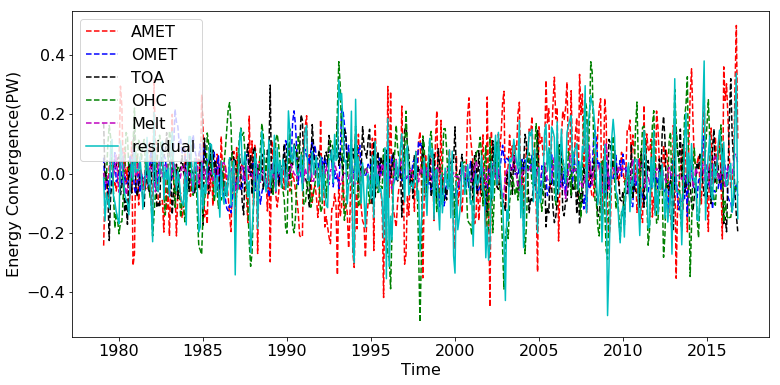

Correlation AMET-Residual
0.37774570966051463
Correlation OMET-Residual
0.17524687193403318
Correlation Rtoa-Residual
-0.029693957646603087
Correlation OHC-Residual
0.4390643255090225
Correlation Melt-Residual
0.158315488900167


In [9]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('=================  AMET res & OMET anomalies 60N-90N  ================')
    
    stat_AMET_res = meta.statistics.operator(AMET_residual)
    stat_AMET_res.anomaly(Dim_month=False)
    residual_overall_anomaly_new = stat_AMET_res._anomaly[:] +\
                                   stat_OMET_ORAS4._anomaly[1:-1,53] +\
                                   np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1) -\
                                   np.sum(OHC_tend_int_anomaly[1:-1,53:],1) -\
                                   np.sum(Heat_SIC_tend_int_anomaly[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2017
    
    fig8 = plt.figure()
    fig8.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_AMET_res._anomaly[:],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_overall_anomaly_new,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig8.savefig(os.path.join(output_path,'energy_budget_overall_anomaly_AMET_res.png'),dpi=300)
    plt.close(fig8)
    # statistics
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 stat_AMET_res._anomaly)
    print (Corr_AMET_Res)
    print ('Correlation OMET-Residual')
    _, _, Corr_OMET_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 stat_OMET_ORAS4._anomaly[1:-1,53])
    print (Corr_OMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation OHC-Residual')
    _, _, Corr_OHC_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                np.sum(-OHC_tend_int_anomaly[1:-1,53:],1))
    print (Corr_OHC_Res)
    print ('Correlation Melt-Residual')
    _, _, Corr_Melt_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1))
    print (Corr_Melt_Res)